In [1]:
import os
os.chdir('../../')

import torch
from torch import distributions as D
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import seaborn as sb

from utils.data import load_data, batch_data
from utils.special_functions import sliding_sum
from utils.priors import IndependentPrior

from models import Bs, Cev, Nig
from inference.ibis import backtest
from inference import KernelSGLD

In [2]:
# Load data
path = 'data/spx_spot.csv'
dates, s = load_data(path, start='2006-01-03', end='2012-12-31')

batch_size = 15
s_batch = batch_data(s, batch_size=batch_size)
print(f"Batched dataset shape: {s_batch.shape}")


Batched dataset shape: torch.Size([117, 15])


In [3]:
torch.manual_seed(0)

dt = torch.tensor(1 / 252)
ESS_rmin = 0.5
window = 100
kernel = KernelSGLD(n_steps=1000, lr=1e-3, lr_min=1e-4, gamma=1.0)

########## Black-Scholes ##########
n_particles = 50
bs_prior = IndependentPrior([
    D.Normal(0.0, 0.1),     # mu
    D.Uniform(0.01, 1.5)    # sigma
])
bs_model = Bs(dt, bs_prior)
bs_hist = backtest(bs_model, kernel, s_batch, s, n_particles, ESS_rmin, window)

########## CEV ##########
n_particles = 50
cev_prior = IndependentPrior([
    D.Normal(0.0, 0.1),         # mu
    D.Uniform(0.01, 200.0),     # delta
    D.Uniform(0.01, 2.5)        # beta
])
cev_model = Cev(dt, cev_prior)
cev_hist = backtest(cev_model, kernel, s_batch, s, n_particles, ESS_rmin, window)

########## NIG ##########
n_particles = 50
nig_prior = IndependentPrior([
    D.Normal(0.0, 0.1),       # mu
    D.Uniform(0.01, 1.5),     # sigma
    D.Uniform(-3.0, 0.0),     # xi
    D.Uniform(0.001, 0.1)     # eta
])
nig_model = Nig(dt, nig_prior)
nig_hist = backtest(nig_model, kernel, s_batch, s, n_particles, ESS_rmin, window)

Batch 0 / 117
ESS=2.26
Resampling...
Batch 1 / 117
ESS=40.56
Batch 2 / 117
ESS=31.23
Batch 3 / 117
ESS=21.71
Resampling...
Batch 4 / 117
ESS=47.54
Batch 5 / 117
ESS=47.48
Batch 6 / 117
ESS=25.65
Batch 7 / 117
ESS=11.41
Resampling...
Batch 8 / 117
ESS=36.51
Batch 9 / 117
ESS=25.47
Batch 10 / 117
ESS=35.71
Batch 11 / 117
ESS=36.64
Batch 12 / 117
ESS=29.83
Batch 13 / 117
ESS=23.74
Resampling...
Batch 14 / 117
ESS=36.99
Batch 15 / 117
ESS=31.37
Batch 16 / 117
ESS=20.88
Resampling...
Batch 17 / 117
ESS=47.85
Batch 18 / 117
ESS=46.49
Batch 19 / 117
ESS=2.15
Resampling...
Batch 20 / 117
ESS=45.06
Batch 21 / 117
ESS=30.13
Batch 22 / 117
ESS=25.89
Batch 23 / 117
ESS=35.15
Batch 24 / 117
ESS=35.16
Batch 25 / 117
ESS=28.93
Batch 26 / 117
ESS=2.37
Resampling...
Batch 27 / 117
ESS=25.19
Batch 28 / 117
ESS=19.19
Resampling...
Batch 29 / 117
ESS=39.19
Batch 30 / 117
ESS=44.32
Batch 31 / 117
ESS=34.14
Batch 32 / 117
ESS=33.28
Batch 33 / 117
ESS=27.96
Batch 34 / 117
ESS=15.52
Resampling...
Batch 35 / 1

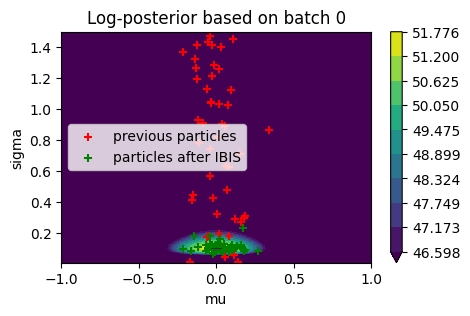

In [4]:
batch_idx = 0
t = (batch_idx + 1) * batch_size
start = max([t-window, 0])
end = t

mu_eval = torch.linspace(-1.0, 1.0, 100)
sigma_eval = torch.linspace(0.01, 1.5, 100)
mu_grid, sigma_grid = torch.meshgrid([mu_eval, sigma_eval], indexing='ij')
pairs = torch.column_stack((mu_grid.ravel(), sigma_grid.ravel()))
transformed_pairs = bs_model.transform.inv(pairs)
lpost = bs_model.lpost(transformed_pairs, s[start:end]).view(100, 100)

plt.figure(figsize=(5, 3))
lpost_max = lpost.max()
levels = torch.linspace(0.9 * lpost_max, lpost_max, 10)
fine_levels = torch.linspace(0.999 * lpost_max, lpost_max, 1)
contour = plt.contourf(mu_grid, sigma_grid, lpost, levels=levels, extend='min')
plt.colorbar(contour)
plt.contour(mu_grid, sigma_grid, lpost, levels=fine_levels, linewidths=0.3)

plt.scatter(bs_hist['particles'][batch_idx][:, 0], bs_hist['particles'][batch_idx][:, 1], label='previous particles', marker='+', c='red')
plt.scatter(bs_hist['particles'][batch_idx+1][:, 0], bs_hist['particles'][batch_idx+1][:, 1], label='particles after IBIS', marker='+', c='green')
plt.xlabel('mu')
plt.ylabel('sigma')
plt.title(f'Log-posterior based on batch {batch_idx}')
plt.legend()
plt.show()

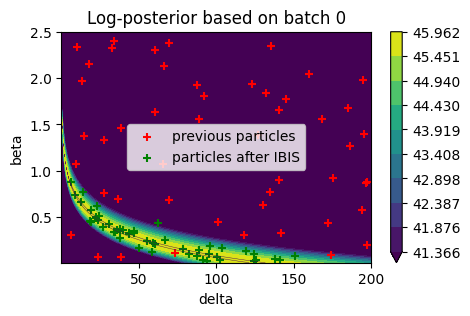

In [5]:
batch_idx = 0
t = (batch_idx + 1) * batch_size
start = max([t-window, 0])
end = t

mu_eval = torch.tensor(0.0)
delta_eval = torch.linspace(0.01, 200.0, 300)
beta_eval = torch.linspace(0.01, 2.5, 300)
delta_grid, beta_grid = torch.meshgrid([delta_eval, beta_eval], indexing='ij')
pairs = torch.column_stack((mu_eval*torch.ones_like(delta_grid.ravel()), delta_grid.ravel(), beta_grid.ravel()))
transformed_pairs = cev_model.transform.inv(pairs)
lpost = cev_model.lpost(transformed_pairs, s[start:end]).view(300, 300)

plt.figure(figsize=(5, 3))
lpost_max = lpost.max()
levels = torch.linspace(0.9 * lpost_max, lpost_max, 10)
fine_levels = torch.linspace(0.999 * lpost_max, lpost_max, 1)
contour = plt.contourf(delta_grid, beta_grid, lpost, levels=levels, extend='min')
plt.colorbar(contour)
plt.contour(delta_grid, beta_grid, lpost, levels=fine_levels, linewidths=0.3)

plt.scatter(cev_hist['particles'][batch_idx][:, 1], cev_hist['particles'][batch_idx][:, 2], label='previous particles', marker='+', c='red')
plt.scatter(cev_hist['particles'][batch_idx+1][:, 1], cev_hist['particles'][batch_idx+1][:, 2], label='particles after IBIS', marker='+', c='green')

plt.xlabel('delta')
plt.ylabel('beta')
plt.title(f'Log-posterior based on batch {batch_idx}')
plt.legend()
plt.show()

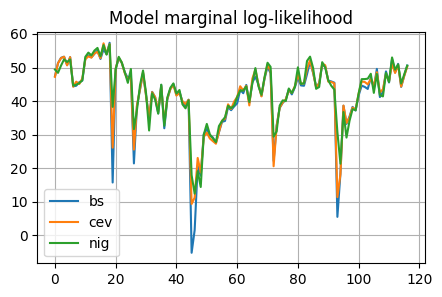

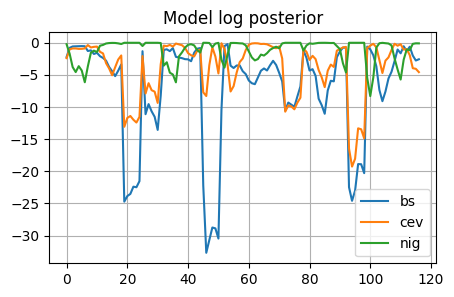

In [6]:
# Model prior
model_prior = torch.ones(size=(3,)) / 3

bs_post = sliding_sum(torch.tensor(bs_hist['ll']), w=window // batch_size) + model_prior[0].log()
cev_post = sliding_sum(torch.tensor(cev_hist['ll']), w=window // batch_size) + model_prior[1].log()
nig_post = sliding_sum(torch.tensor(nig_hist['ll']), w=window // batch_size) + model_prior[2].log()

tmp = torch.stack([bs_post, cev_post, nig_post])
lnorm_constant = torch.logsumexp(tmp, dim=0)
bs_lpost = bs_post - lnorm_constant
cev_lpost = cev_post - lnorm_constant
nig_lpost = nig_post - lnorm_constant

plt.figure(figsize=(5, 3))
plt.plot(bs_hist['ll'], label='bs')
plt.plot(cev_hist['ll'], label='cev')
plt.plot(nig_hist['ll'], label='nig')
plt.grid()
plt.legend()
plt.title('Model marginal log-likelihood')
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(bs_lpost, label='bs')
plt.plot(cev_lpost, label='cev')
plt.plot(nig_lpost, label='nig')
plt.grid()
plt.legend()

plt.title('Model log posterior')
plt.show()

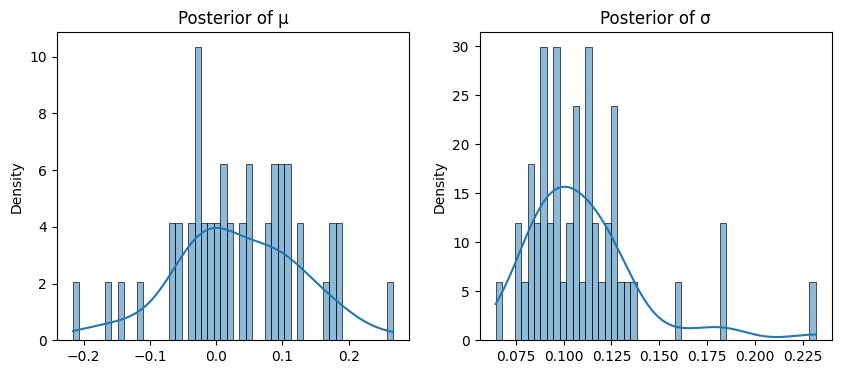

In [7]:
batch_idx = 0

particles = bs_hist['particles'][batch_idx+1]
weights = bs_hist['weights'][batch_idx+1]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sb.histplot(x=particles[:, 0].numpy(), weights=weights.numpy(), bins=50, stat="density", kde=True)
plt.title("Posterior of μ")

plt.subplot(1, 2, 2)
sb.histplot(x=particles[:, 1].numpy(), weights=weights.numpy(), bins=50, stat="density", kde=True)
plt.title("Posterior of σ")
plt.show()

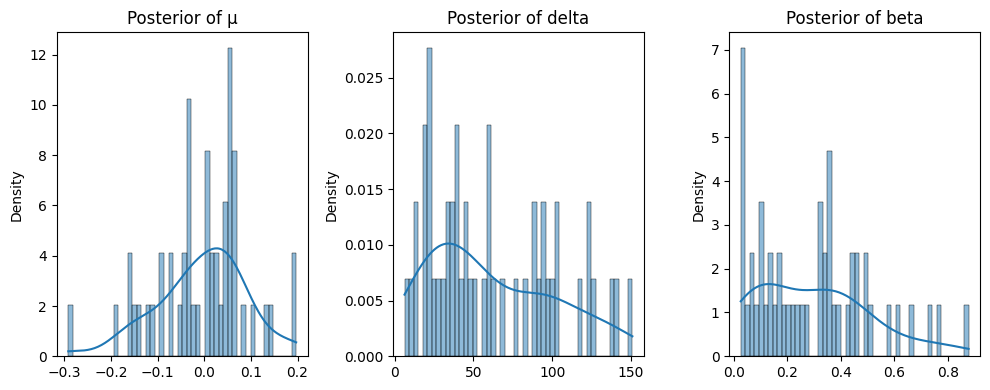

In [8]:
batch_idx = 0

particles = cev_hist['particles'][batch_idx+1]
weights = cev_hist['weights'][batch_idx+1]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
sb.histplot(x=particles[:, 0].numpy(), weights=weights.numpy(), bins=50, stat="density", kde=True)
plt.title("Posterior of μ")

plt.subplot(1, 3, 2)
sb.histplot(x=particles[:, 1].numpy(), weights=weights.numpy(), bins=50, stat="density", kde=True)
plt.title("Posterior of delta")

plt.subplot(1, 3, 3)
sb.histplot(x=particles[:, 2].numpy(), weights=weights.numpy(), bins=50, stat="density", kde=True)
plt.title("Posterior of beta")

plt.tight_layout()
plt.show()

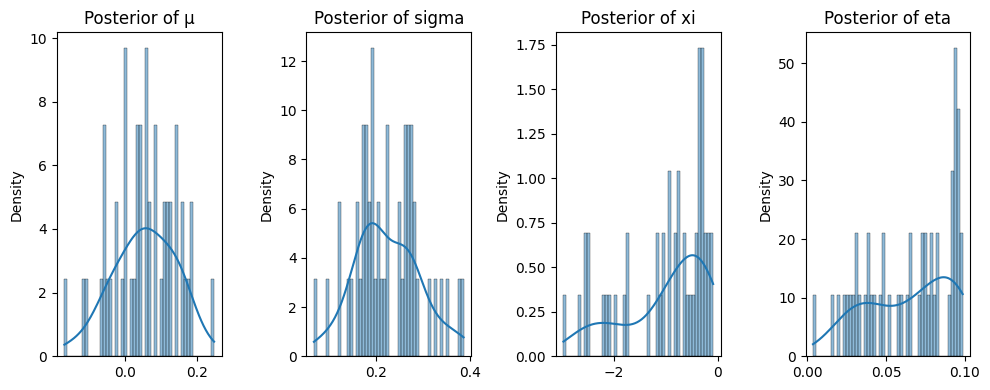

In [9]:
batch_idx = 0

particles = nig_hist['particles'][batch_idx+1]
weights = nig_hist['weights'][batch_idx+1]

plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
sb.histplot(x=particles[:, 0].numpy(), weights=weights.numpy(), bins=50, stat="density", kde=True)
plt.title("Posterior of μ")

plt.subplot(1, 4, 2)
sb.histplot(x=particles[:, 1].numpy(), weights=weights.numpy(), bins=50, stat="density", kde=True)
plt.title("Posterior of sigma")

plt.subplot(1, 4, 3)
sb.histplot(x=particles[:, 2].numpy(), weights=weights.numpy(), bins=50, stat="density", kde=True)
plt.title("Posterior of xi")

plt.subplot(1, 4, 4)
sb.histplot(x=particles[:, 3].numpy(), weights=weights.numpy(), bins=50, stat="density", kde=True)
plt.title("Posterior of eta")

plt.tight_layout()
plt.show()